In [14]:
from utils import *
from plotting import *
from models import *


plt.offline.init_notebook_mode()
plt.io.templates.default = "none"


Get count data

In [15]:
def load_counts(counts_fn, types_fn, type_subset=None):
    
    # probably don't want str input
    if isinstance(type_subset, str):
        warnings.warn("For str type_subset, each letter is matched. Are you sure you don't want list?", UserWarning)
        
    counts = pd.read_csv(counts_fn, index_col = [0], header = [0])[mut96]
    cancer_types = pd.read_csv(types_fn)
    cancer_types.columns=['type', 'guid']
    
    # subset guid by matching cancer type
    if type_subset is not None:
        
        # partial matches allowed
        sel = np.fromiter((map(any, zip(*[cancer_types.type.str.contains(x) for x in type_subset] ))), dtype = bool)
        
        # type should appear in the type column of the lookup 
        assert sel.any(), 'Cancer type subsetting yielded no selection. Check keywords?'
        
        counts = counts.loc[cancer_types.guid[sel]]

    return counts#.to_numpy()

In [16]:
mcols = pd.read_csv('icgc_sample_annotations_summary_table.txt', sep='\t').set_index('tumour_aliquot_id')

In [17]:
# order staging info
mcols.tumour_stage = pd.Categorical(mcols.tumour_stage, ordered = True, categories = ['nan','unknown', '1', '1a', '1b', '2', '2a', '2b', '3', '3a', 
                                            '3b', '3c', '4', 'A', 'B', 'C', 'I', 'IA', 'IB', 'II', 'IIA', 
                                            'IIB', 'III', 'IIIA', 'IIIB', 'IIIC', 'IV', 'IVA',  'T1N0',
                                            'T1N0M0', 'T1N0MX', 'T1N0Mx', 'T1N1M0', 'T1N1M1', 'T1N1Mx',
                                            'T1N1bMX', 'T1N3M0', 'T1aN0M0', 'T1aNXMX', 'T1bN0M0', 'T1bN0M1',
                                            'T1bN0MX', 'T1bNXMX', 'T1c', 'T2N0M0', 'T2N0M1', 'T2N0MX',
                                            'T2N0Mx', 'T2N1M0', 'T2N1M1', 'T2N1MX', 'T2N1Mx', 'T2N1aMx',
                                            'T2N1bMX', 'T2N2M0', 'T2N2M2', 'T2N3M0', 'T2NxM0', 'T2NxMx', 'T2a',
                                            'T2aN0', 'T2aN1MX', 'T2aNXMX', 'T2b', 'T2bNXMX', 'T2c', 'T2cN0',
                                            'T2cN0Mx', 'T2cN1', 'T2cNX', 'T2cNxMx', 'T3N0', 'T3N0M0', 'T3N0M1',
                                            'T3N0MX', 'T3N0Mx', 'T3N1M0', 'T3N1M1', 'T3N1M2', 'T3N1MX',
                                            'T3N1Mx', 'T3N1aMX', 'T3N1bMX', 'T3N2M0', 'T3N3M0', 'T3NXMX',
                                            'T3a', 'T3aN0', 'T3aN0M0', 'T3aN0MX', 'T3aN0Mx', 'T3aN1MX',
                                            'T3aNX', 'T3aNXMX', 'T3aNxMx', 'T3b', 'T3bN0', 'T3bN0Mx', 'T3bN1',
                                            'T3bN1M0', 'T3bNXMX', 'T3bNxMx', 'T3cN0M0', 'T4N0M0', 'T4N1',
                                            'T4N1M0', 'T4N1M1', 'T4N1bM1', 'T4N2M0', 'T4N2M1', 'T4N3M0',
                                            'T4NXMX', 'T4aN2', 'TXNXM1', 'TxNxMx',  'pT2N0M0', 'pT2N2bM0', 
                                            'pT4aN0M0', 'pT4aN1M0', 'pT4aN2bM0', 'M0', 'M1', 'M2', 'M3'])

In [18]:
counts = load_counts('mutation_types_raw_counts.csv', 'pcawg_cancer_types.csv', ['Skin'])
mcols = mcols.loc[counts.index]
counts = counts.to_numpy()
#train, test = split_by_S(counts)
#trp, trpp = split_by_count(train)
#tsp, tspp = split_by_count(test)

In [19]:
# constants
C = 32
M = 3

J=5
K=4

N = counts.sum(1)
S = len(N)
print(S)

107


Get signature data

In [21]:
cosmic = load_sigs('COSMIC_v3.2_SBS_GRCh37.txt', 'cosmic', sep = '\t')
pcawg_local = load_sigs('pcawg_localsigs.csv')
degas_local = load_sigs('degasperi_localsigs.csv', 'cosmic')

In [10]:
# get signature names
cosmic_names = np.array(cosmic.columns)
pcawg_names = np.array(pcawg_local.columns)
degas_names = np.array(degas_local.columns)

# turn signatures to numpy for sanity
cosmic = cosmic.to_numpy().T
pcawg_local = pcawg_local.to_numpy().T
degas_local = degas_local.to_numpy().T

# subset to skin-active signatures
np.where(np.array(cosmic_names) == 'SBS18')

cosmic_names[[62, 63, 12, 34]]
#pcawg_names[[]]

array(['SBS56', 'SBS57', 'SBS10a', 'SBS28'], dtype=object)

In [11]:
counts.shape
#plot_sigs(train, row_title='Sample').update_layout(height = 10000)

(107, 96)

Preview samples

In [13]:
from sklearn.decomposition import PCA
from plotly.subplots import make_subplots


def plot_elbow_pca(X, n_comp=10, mcol=None):
    fig = go.Figure()
    # X is row-data
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X)
    # plot PC elbow
    r = pca.explained_variance_ratio_
    fig.add_trace(go.Scatter(x=np.arange(len(r)), y=r, mode='lines+markers',
                             name = '% variance explained'), row=1, col=1)
    
    ## plot PC 1 & 2
    #fig.add_trace(go.Scatter(x=X_pca[:, 0], y=X_pca[:, 1],
    #                         marker=dict(color=mcol, #set color equal to a variable
    #                                     colorscale='Agsunset',
    #                                     showscale=(mcol is not None),
    #                                     colorbar=dict(len=0.5)
    #                                    ),
    #                         mode='markers', name = "PC1/2"), row = 1, col = 2)
    #
    #
    return fig
    

plot_elbow_pca(counts,10).show()

Exception: In order to reference traces by row and column, you must first use plotly.tools.make_subplots to create the figure with a subplot grid.

In [15]:
mcols.purity.dtype!=float and mcols.purity!=int

False

In [16]:
from sklearn.decomposition import PCA
from plotly.subplots import make_subplots


def plot_pca(X, mcol=None):
    # X is row-data
    # mcol is (optional) colouring factor
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # pull out labels for categorical mcol
    if mcol.dtype!=float:
        col = mcol.astype('category').cat.codes
    else: 
        col = mcol
        mcol = mcol.round(2)
    
    # plot PC 1 & 2
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_pca[:, 0], y=X_pca[:, 1],
                             marker=dict(color=col, #set color equal to a variable
                                         colorscale='Agsunset',
                                         showscale=(mcol is not None),
                                         colorbar=dict(len=0.5)
                                        ),
                             customdata=mcol,
                             hovertemplate = '%{customdata}<extra></extra>',
                             mode='markers', name='pc1/2'))
    
    if hasattr(mcol, 'name'):
        fig.update_layout(title=f"coloured by {mcol.name}")
    fig.update_layout(xaxis_title="PC1",
                      yaxis_title="PC2")
    
    return fig


plot_pca(counts, mcol = mcols.tumour_stage).show()

In [17]:
centroids = init_sigs('kmeans', data=counts, J=J, K=K)
#plot_sigs(centroids['phi'], cols = '#a64d79', xlab=mut32, row_title = 'Phi').update_layout(height = 500).show()
#plot_sigs(centroids['eta'].reshape(-1,6), cols = '#45818e', xlab = mut6, row_title = 'Eta').update_layout(height = 500).show()

In [18]:
#def plotly_grid(list_of_plots, grid_matrix):
#    # unpack plots to place them all on a subplot matrix
#    traces = np.concatenate([np.array([*p.data]) for p in list_of_plots])
#    fig = go.make_subplots()
#    for t, r, c in zip(traces, grid_matrix):
#        fig.add_trace(t, row=r, col=c)
#    return fig

use model factory to amend size conflicts in test

In [19]:
model = collapsed_model_factory(counts, J, K, 1, 1, 1, 1, init_strategy = 'kmeans') 

In [20]:
with model:
    trace = pm.fit(30000, method='advi')
    baby_trace = pm.fit(1,method="advi")

Diagnostic plots

In [21]:
fig = go.Figure(data=go.Scatter(x=np.arange(trace.hist.shape[0]), y=trace.hist))
fig.update_layout(title="ELBO", xaxis_title = 'iteration', height = 400)

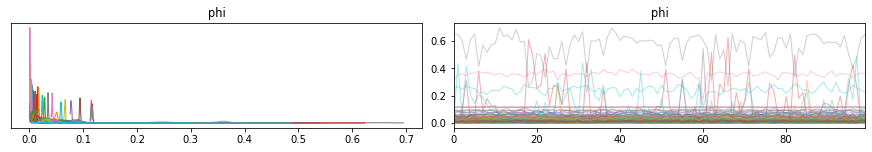

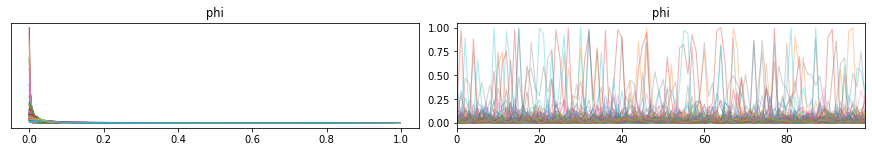

In [22]:
with model:
    #pm.plot_trace(trace.sample(100), var_names = 'theta');
    #pm.plot_trace(trace.sample(100), var_names = 'A');
    pm.plot_trace(trace.sample(100), var_names = 'phi');
    #pm.plot_trace(trace.sample(100), var_names = 'eta');
    pm.plot_trace(baby_trace.sample(100), var_names = 'phi');

In [23]:
hat = trace.sample(1000)
w = np.einsum('tsj,tsjk -> tsjk', hat.theta, hat.A)

In [24]:
#plot_phi_posterior(baby_trace.sample(1000).phi, cols = None)

In [25]:
mcols.columns
mcols.dtypes

histology_abbreviation             object
icgc_sample_id                     object
purity                            float64
ploidy                            float64
wgd_status                         object
purity_conf_mad                   float64
num_subclones                       int64
num_clonal_snvs                   float64
num_subclonal_snvs                float64
num_clonal_indels                 float64
num_subclonal_indels              float64
num_clonal_svs                    float64
num_subclonal_svs                 float64
icgc_donor_id                      object
tumour_type                        object
reported_sex                       object
inferred_sex                       object
donor_survival_time               float64
donor_age_at_diagnosis            float64
tumour_stage                     category
tumour_grade                       object
first_therapy_type                 object
first_therapy_response             object
specimen_donor_treatment_type     

In [26]:
n_comp = 5

In [1]:
for i in range(len(mcols.columns)):
    plot_pca(hat.A.mean(0).reshape(-1, J*K), mcol = mcols[mcols.columns[i]]).show()
        

NameError: name 'mcols' is not defined

In [ ]:
# color by theta for each context signature
for j in range(J):
    f = plot_pca(hat.A.mean(0).reshape(-1, J*K), mcol = hat.theta.mean(0)[:,j])
    f.update_layout(title=f"coloured by activity of context signature {j}")
    f.show()

Get correlation for PCs and metadata, A, w

In [ ]:
# corr automoatically splits out numeric columns that can actually get correlation
# TODO: add ordinals in for tumour subtype, grade

pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(hat.A.mean(0).reshape(-1, J*K))
c = pd.concat([mcols, 
               pd.DataFrame(X_pca, index = mcols.index, columns = [f'compunent_{i}' for i in range(n_comp)]),
               pd.DataFrame(hat.theta.mean(0), index = mcols.index, columns = [f'theta_{j}' for j in range(J)])],
              axis=1).corr()
f = go.Figure().add_trace(go.Heatmap(z=c**2, colorscale = 'agsunset', 
                                     x = c.columns, y=c.columns))
f.update_layout(title=f"PCA of A")

In [ ]:
for i in range(len(mcols.columns)):
    plot_pca(w.mean(0).reshape(-1, J*K), mcol = mcols[mcols.columns[i]]).show()


In [ ]:
# color by theta for each context signature
for j in range(J):
    f = plot_pca(w.mean(0).reshape(-1, J*K), mcol = hat.theta.mean(0)[:,j])
    f.update_layout(title=f"coloured by activity of context signature {j}")
    f.show()

In [ ]:
# corr automoatically splits out numeric columns that can actually get correlation
# TODO: add ordinals in for tumour subtype, grade

pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(w.mean(0).reshape(-1, J*K))
c = pd.concat([mcols,
               pd.DataFrame(X_pca, index = mcols.index, columns = [f'compunent_{i}' for i in range(n_comp)]),
               pd.DataFrame(hat.theta.mean(0), index = mcols.index, columns = [f'theta_{j}' for j in range(J)])],
              axis=1).corr()
f = go.Figure().add_trace(go.Heatmap(z=c**2, colorscale = 'agsunset', 
                                     x = c.columns, y=c.columns))
f.update_layout(title=f"PCA on theta x A")

In [ ]:
for s in range(3):
    plot_bipartite(hat.A.mean(0)[s]).update_layout(title = f'A for sample {s}').show()
    
for s in range(3):
    plot_bipartite(hat.A.mean(0)[s]).update_layout(title = f'theta x A for sample {s}').show()

In [ ]:
n_comp = 5
pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(hat.A.mean(0).reshape(-1, J*K))

# positive orange, negative blue
for i in range(n_comp):
    edges = pca.components_.reshape(-1, J, K)[i]
    edge_colours = np.tile('#f6b26b', J*K)
    edge_colours[edges.flatten() < 0] = '#6fa8dc'
    f = plot_bipartite(abs(edges), edge_cols = edge_colours, thresh = 0.1)
    f.update_layout(title=f"A component {i}")
    f.show()


In [ ]:
n_comp = 5
pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(w.mean(0).reshape(-1, J*K))

for i in range(n_comp):
    edges = pca.components_.reshape(-1, J, K)[i]
    edge_colours = np.tile('#f6b26b', J*K)
    edge_colours[edges.flatten() < 0] = '#6fa8dc'
    plot_bipartite(abs(edges), edge_cols = edge_colours).show()
    f.update_layout(title=f"theta x A component {i}")
    f.show()

In [ ]:
#PCA(n_components=2).fit_transform(w.reshape(-1, J*K))
#km = k_means(w.reshape(-1, J*K), 7)

In [ ]:
plot_phi(hat.phi.mean(0)).show()
plot_eta(hat.eta.mean(0)).show()

In [ ]:
#go.Figure(go.Heatmap(z=cosine_similarity(hat.phi.mean(0),hat.phi.mean(0)).round(2), colorscale = 'viridis'))

In [ ]:
#go.Figure(go.Heatmap(z=cosine_similarity(flatten_eta(hat.eta.mean(0)),flatten_eta(hat.eta.mean(0))).round(2), colorscale = 'viridis'))

In [ ]:
tau_hat = get_tau(hat.phi.mean(0),hat.eta.mean(0))
plot_tau(tau_hat).show().update_layout(height = 1000)

In [ ]:
#plot_cossim(get_phis(pcawg_local), hat.phi.mean(0))

In [ ]:
#plot_cossim(pcawg_local, tau_hat)

In [ ]:
#plot_cossim(get_phis(cosmic), hat.phi.mean(0))

In [ ]:
#plot_cossim(get_etas(cosmic), get_etas(cosmic))

In [ ]:
plot_cossim(cosmic, tau_hat)

In [ ]:
cosmic_names[np.any(cosine_similarity(tau_hat,cosmic) > 0.7, axis = 0)]

In [ ]:
cosmic_names[np.any(cosine_similarity(hat.phi.mean(0), get_phis(cosmic) ) > 0.7, axis = 0)]

In [ ]:
cosmic_names[np.any(cosine_similarity(hat.eta.mean(0).reshape(-1,6), get_etas(cosmic) ) > 0.9, axis = 0)]

import arviz as az
with model:
    ppc = pm.sample_posterior_predictive(trace.sample(100), var_names=["corpus"])
    
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));

ppc['corpus'].shape

In [ ]:
alp_B(counts, hat.B.mean(0))

In [ ]:
def alp_B(data, B):
    return (data * np.log(B)).sum() / data.sum()